<a href="https://colab.research.google.com/github/sriramanush105/IMGEDIT/blob/master/imgedit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#importing required packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import os
import numpy as np
import PIL.Image
import time
import functools
from PIL import Image

In [50]:
#converting image to tensor
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)

  # Workaround
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, np.float32)

  img = img[tf.newaxis, :]
  
  return img

In [70]:
#converting tensor to image
def tensor_to_image(tensor):
    tensor = tf.image.convert_image_dtype(tensor, np.uint8)
    tensor = tf.squeeze(tensor)

    
    c=tf.keras.backend.eval(tensor)
    plt.imsave("new.jpg",c)
    return None

In [51]:
#code for displaying image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [94]:
#defining model architecture

model_=Sequential()

model_.add(tf.keras.layers.Conv2D(16,(3,3),activation="relu",padding="same"))

model_.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))


model_.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))

model_.add(tf.keras.layers.Conv2D(3,(3,3),activation="relu",padding="same"))


(1, 225, 225, 3)


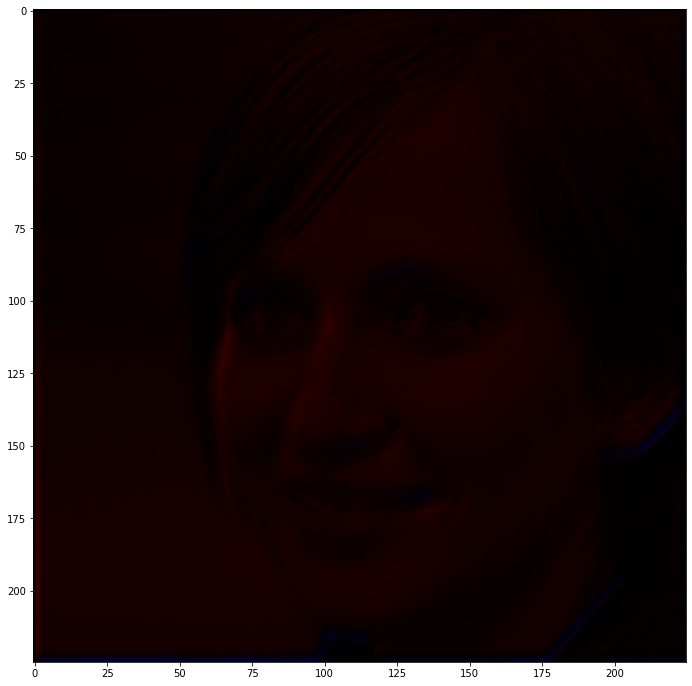

In [66]:
#reviewing model output to select correct weights
content_image=load_img("/content/drive/My Drive/images/40.jfif")
x=model_(content_image)
print(x.shape)
imshow(x)

In [71]:
tensor_to_image(x)

In [72]:
#defining style and content extractor from layers of vgg
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    print("hello")
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    print("good")
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}  
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model    

hello
good


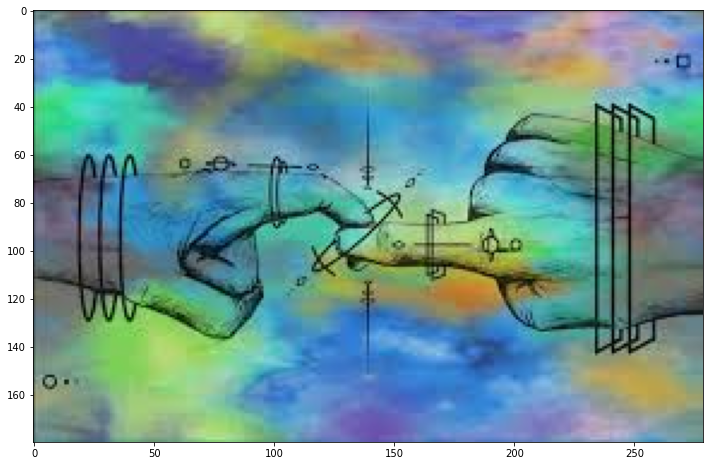

In [93]:
extractor = StyleContentModel(style_layers, content_layers)#this extracts style and content layers in dict format

#extracting style layers from style image
style_image=load_img("/content/link.jfif")#insert path to style image
style_targets = extractor(style_image)['style']
imshow(style_image)


In [74]:
#loss function
def style_content_loss(outputs,content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
  
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = content_loss+style_loss 
    
    return loss

In [75]:
#defining optimizer 
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [ ]:
#preloading images to tensor type for improving epoch speed
#replace path with your own image folder paths to load images
#l=[]

images=[load_img("/content/drive/My Drive/images1/"+i)for i in os.listdir("/content/drive/My Drive/images1/")]+[load_img("/content/drive/My Drive/images/"+i)for i in os.listdir("/content/drive/My Drive/images/")]
cont=[extractor(images[i])["content"] for i in range(len(images))]
lent=len(images)

In [95]:
#gradient tape for training

def train_step(images,step):
  c=tf.Variable(initial_value=0,dtype="float32")
  
  
  with tf.GradientTape() as tape:
    for i in range(int(22)):
      w=(i+step)%lent
    
      content_targets=cont[w]
      outputs = extractor(model_(images[w]))
      loss = style_content_loss(outputs,content_targets)
      total_variation_weight=30
      loss += total_variation_weight*tf.image.total_variation(model_(images[w]))
      c=c+loss
      del content_targets
      del outputs
    loss=tf.reduce_mean(c) 
    print("loss:",loss) 
  gradients = tape.gradient(loss, model_.trainable_variables)
  opt.apply_gradients(zip(gradients, model_.trainable_variables))
  
  


In [ ]:
#training
step=0
for p in range(1000):
  train_step(images,step)
  step=step+22
  print("epoch",(p))


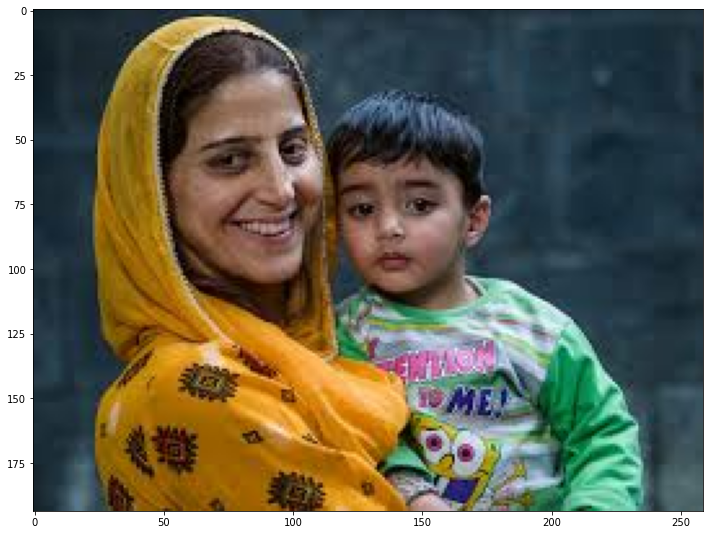

In [91]:
x=load_img("/content/drive/My Drive/face/20.jfif")
imshow(x)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


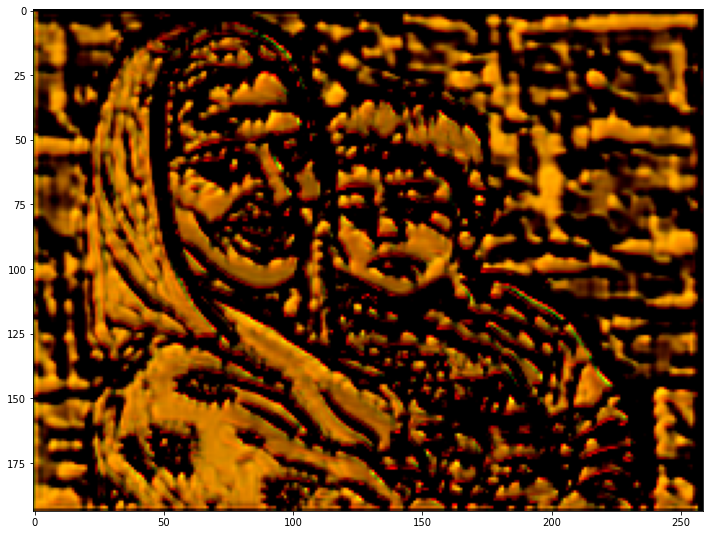

In [92]:
p=model_(x)
imshow(p)

In [ ]:
model_.save("mymodel.h5")

In [ ]:
print(tf.__version__)

2.3.0
